# Analyzing Negative Google Play Store Reviews using K-means Clustering and Latent Dirichlet Allocation

![Word Cloud](wordcloud.png)

# Project Overview
As a personal project, this notebook aims to analyze negative reviews from the Google Play Store to better understand user complaints and identify recurring issues. By applying K-means clustering and Natural Language Processing (NLP) techniques, the reviews will be categorized into distinct clusters, allowing for a deeper insight into the common themes among dissatisfied users.

# Dataset
The dataset contains reviews from the Google Play Store, including the following columns:

'content': The text content of each review.
'score': The score assigned to the review by the user, ranging from 1 to 5.
For this analysis, we will focus on the reviews with scores of 1 or 2, which represent the most negative feedback.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from collections import Counter
from textblob import TextBlob

In [2]:
# Download necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# max clusters
max_clusters = 50

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sahle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading and Exploration
We have loaded the reviews dataset and displayed the first few rows to understand its structure.


In [3]:
# Load the reviews dataset and preview it
reviews = pd.read_csv("reviews.csv")
reviews.head()

,content,score
0,I cannot open the app anymore,1
1,I have been begging for a refund from this app...,1
2,Very costly for the premium version (approx In...,1
3,"Used to keep me organized, but all the 2020 UP...",1
4,Dan Birthday Oct 28,1


## Preprocess the negative reviews

### Data Preprocessing
We are filtering out negative reviews (scores 1 or 2) for further analysis.


In [4]:
# Filter negative reviews (having a score of 1 or 2)
negative_reviews_tmp = reviews[reviews['score'] <= 2]["content"]
negative_reviews_tmp.head()

0                        I cannot open the app anymore
1    I have been begging for a refund from this app...
2    Very costly for the premium version (approx In...
3    Used to keep me organized, but all the 2020 UP...
4                                  Dan Birthday Oct 28
Name: content, dtype: object

In [5]:
negative_reviews_tmp.shape

(4850,)

### Text Preprocessing
We have preprocessed the negative reviews by converting them to lowercase, tokenizing, and removing stopwords and non-alphabetic tokens.


In [6]:
def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts.

    This function first tags the word with its POS using NLTK's pos_tag function. 
    The first character of the POS tag is extracted and converted to uppercase 
    (e.g., 'NN' -> 'N'). A dictionary (tag_dict) is used to map the first character 
    to a WordNet POS tag. If the tag is not in the dictionary, the function defaults 
    to wordnet.NOUN.

    Parameters:
    word (str): A single word (token) whose POS tag needs to be mapped.

    Returns:
    str: A POS tag that the WordNet lemmatizer can use (wordnet.VERB, wordnet.NOUN, 
         wordnet.ADJ, or wordnet.ADV). If the POS tag is not in the predefined 
         mapping, it defaults to wordnet.NOUN.

    Example:
    >>> get_wordnet_pos("running")
    'v'
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

# Function to preprocess text
def preprocess_text(text):
    """
    Tokenizes, removes stop words and punctuation, and lemmatizes the input text.
    
    Parameters:
        text (str): The input text to preprocess.
    
    Returns:
        str: The preprocessed text.
    """
    tokens = word_tokenize(text.lower())  # Convert text to lowercase and tokenize
    lemmatized_tokens = [
        lemmatizer.lemmatize(token, pos=get_wordnet_pos(token))
        for token in tokens
        if token.isalpha() and token.lower() not in stopwords.words("english")
    ]
    return ' '.join(lemmatized_tokens)

In [7]:
negative_reviews_cleaned = negative_reviews_tmp.apply(preprocess_text)

preprocessed_reviews = pd.DataFrame({"review": negative_reviews_cleaned})
preprocessed_reviews.head()

,review
0,open app anymore
1,beg refund app month nobody reply
2,costly premium version approx indian rupee per...
3,use keep organize update make mess thing cud u...
4,dan birthday oct


## TF-IDF Vectorization
We have converted the cleaned text into numerical features using TF-IDF vectorization, which is suitable for clustering analysis.


In [8]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_reviews["review"])


##  K-means clustering

### Elbow Method
We have plotted the elbow method to further determine the optimal number of clusters for K-means clustering.


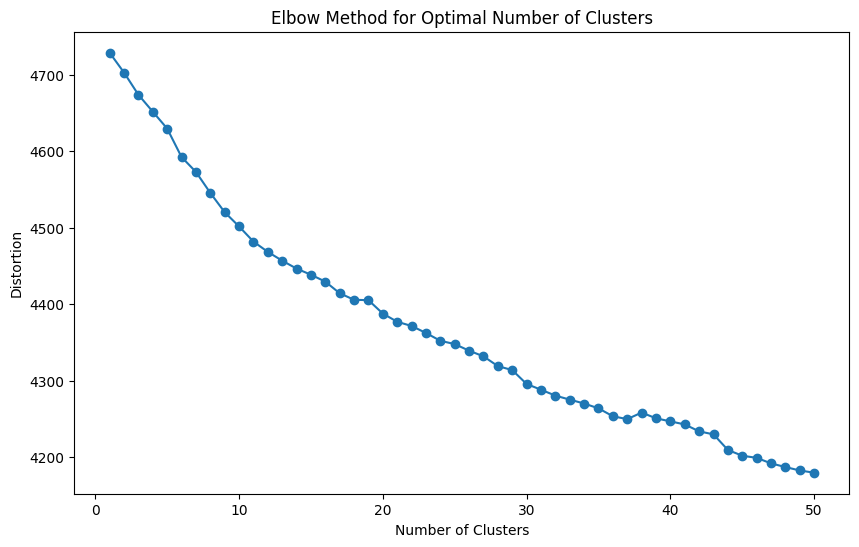

In [9]:
def plot_elbow_method(tfidf_matrix, max_clusters=15):
    distortions = []

    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=500)
        kmeans.fit(tfidf_matrix)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title("Elbow Method for Optimal Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Distortion")
    plt.show()

plot_elbow_method(tfidf_matrix, max_clusters=max_clusters)


The plot shows a gradual decrease in distortion with no clear "elbow" point(maybe at 11) Trying a different metric silhouette score

### Silhouette Scores
We have plotted the silhouette scores for different numbers of clusters to determine the optimal number of clusters for K-means clustering.


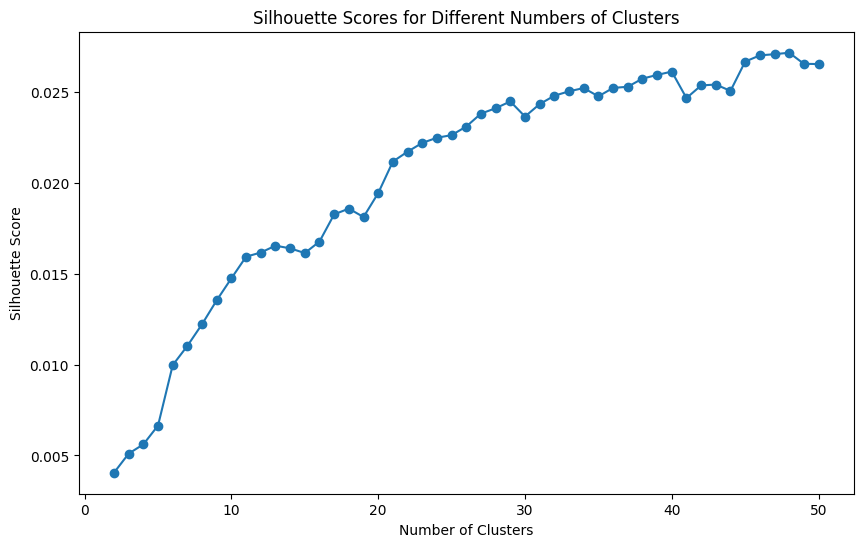

In [10]:
def plot_silhouette_scores(tfidf_matrix, max_clusters=10):
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=500)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)
        silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title("Silhouette Scores for Different Numbers of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

plot_silhouette_scores(tfidf_matrix, max_clusters=max_clusters)

The "elbow method" helps us figure out the best number of clusters to use in K-means clustering. We do this by plotting how much the data is spread out within the clusters against the number of clusters we create. 

In our case, the plot shows a steady decrease in distortion as the number of clusters increases, but there's no clear elbow. It looks like there might be a slight bend around 11 clusters. We also looked at the silhouette score, which measures how well each data point fits into its cluster. This score steadily improves with a noticeable change in increase at 10 clusters and at 20 clusters.

Generally get better scores the more clusters you use because each data point has a better chance of fitting neatly into a cluster since we don't want too many clusters, which can make the model harder to interpret, we'll go with 11 

In [11]:
# Number of clusters
n_clusters = 11

### Clustering

In [12]:
clust_kmeans = KMeans(n_clusters= n_clusters, random_state=500)
pred_labels = clust_kmeans.fit_predict(tfidf_matrix)

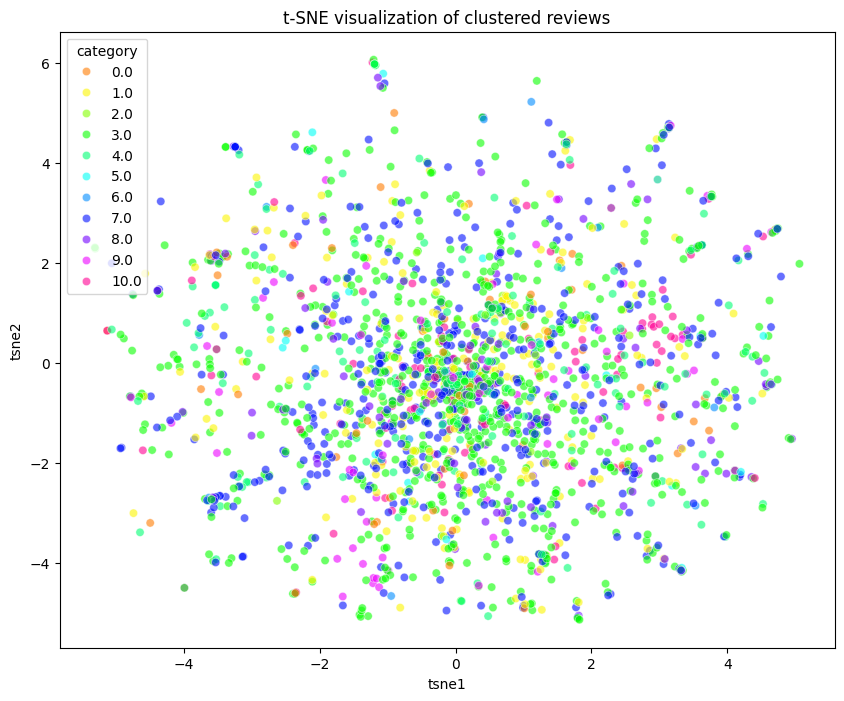

In [14]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=500)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['category'] = preprocessed_reviews['category']

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne1', y='tsne2',
    hue='category',
    palette=sns.color_palette('hsv', clust_kmeans.n_clusters),
    data=tsne_df,
    legend='full',
    alpha=0.6
)
plt.title("t-SNE visualization of clustered reviews")
plt.show()


### PCA Visualization
We have reduced the dimensionality of the TF-IDF vectors using PCA and visualized the clusters in 2D space.


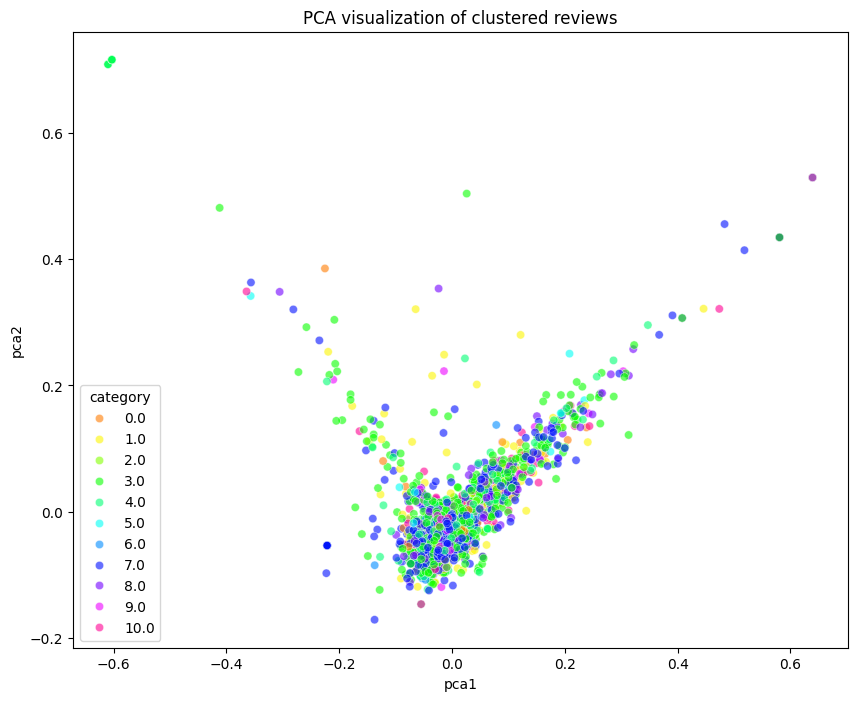

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the tf-idf matrix
clust_kmeans = KMeans(n_clusters=n_clusters, random_state=500)
pred_labels = clust_kmeans.fit_predict(tfidf_matrix)

preprocessed_reviews["category"] = pred_labels

# Reduce dimensionality using PCA
pca = PCA(n_components=2, random_state=500)
pca_results = pca.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame with the PCA results and cluster labels
pca_df = pd.DataFrame(pca_results, columns=['pca1', 'pca2'])
pca_df['category'] = preprocessed_reviews['category']

# Plot the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca1', y='pca2',
    hue='category',
    palette=sns.color_palette('hsv', n_clusters),
    data=pca_df,
    legend='full',
    alpha=0.6
)
plt.title("PCA visualization of clustered reviews")
plt.show()

### Most Common Terms in Each Cluster
We have identified and displayed the most common terms in each cluster to understand the themes and topics within each cluster.


In [16]:
# Import necessary libraries
from collections import Counter

# Get the feature names (terms) from the vectorizer
terms = vectorizer.get_feature_names_out()

# Initialize a list to store the most common terms for each cluster
top_terms_per_cluster = []

for cluster in range(n_clusters):
    # Get indices of reviews in the current cluster
    cluster_indices = [i for i, label in enumerate(pred_labels) if label == cluster]

    # Get the reviews in the current cluster
    cluster_reviews = [preprocessed_reviews.iloc[i]['review'] for i in cluster_indices]

    # Count the frequency of each term in the cluster
    all_words = ' '.join(cluster_reviews).split()
    most_common_words = Counter(all_words).most_common(10)  # Adjust the number to get more terms

    # Append the cluster and its most common terms to the list
    top_terms_per_cluster.append({
        "cluster": cluster,
        "terms": most_common_words
    })

# Display the most common terms for each cluster
for cluster_info in top_terms_per_cluster:
    print(f"Cluster {cluster_info['cluster']}:")
    print(cluster_info['terms'])
    print("\n")




Cluster 0:
[('notification', 280), ('app', 145), ('work', 60), ('get', 55), ('reminder', 41), ('time', 39), ('task', 32), ('set', 30), ('sound', 28), ('like', 26)]


Cluster 1:
[('task', 736), ('app', 461), ('calendar', 387), ('list', 292), ('add', 178), ('use', 178), ('day', 168), ('google', 165), ('time', 157), ('sync', 148)]


Cluster 2:
[('ad', 303), ('app', 150), ('calendar', 83), ('use', 74), ('screen', 63), ('full', 56), ('add', 36), ('free', 35), ('version', 35), ('update', 34)]


Cluster 3:
[('app', 297), ('like', 194), ('time', 190), ('get', 164), ('ca', 155), ('even', 139), ('make', 136), ('update', 133), ('want', 124), ('feature', 121)]


Cluster 4:
[('version', 368), ('pro', 200), ('app', 173), ('free', 170), ('use', 81), ('tree', 72), ('premium', 70), ('paid', 63), ('buy', 60), ('feature', 59)]


Cluster 5:
[('bad', 75), ('app', 27), ('ever', 4), ('download', 4), ('use', 3), ('work', 3), ('make', 3), ('good', 3), ('phone', 3), ('experience', 3)]


Cluster 6:
[('good', 54)

## Latent Dirichlet Allocation

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

In [26]:
# Apply LDA
lda = LatentDirichletAllocation(n_components=11, random_state=42)  # Set the number of topics
lda.fit(tfidf_matrix.toarray())

# Function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
bad tree app pro plant coin specie want understand use
Topic 1:
work notification reminder confuse alarm app task suck ring anymore
Topic 2:
app feature reminder free habit pay task premium use well
Topic 3:
dont alexa feature project usefull name like interest holiday pay
Topic 4:
complicate login facebook sign log account na password complex require
Topic 5:
dark expensive theme ok mode comment application useful kick load
Topic 6:
app good work time ad use version get update task
Topic 7:
calendar app sync use google ad useless work task get
Topic 8:
version app free like terrible buy premium pay hate stupid
Topic 9:
account create app subscription love lock everything let behind list
Topic 10:
app task use try time work account phone ca day


## Generate a Word Cloud
Next, we generate a word cloud from the cleaned text of negative reviews to visualize the most frequent terms.

In [17]:
# from wordcloud import WordCloud

# preprocessed_reviews

# # Combine all cleaned reviews into a single string
# combined_text = ' '.join(preprocessed_reviews['review'])

# # Generate the word cloud
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# wordcloud.to_file("wordcloud.png")

### Conclusion

LDA (Latent Dirichlet Allocation) and K-means clustering offer unique advantages for text analysis, each serving different purposes.

**LDA (Latent Dirichlet Allocation)**:
- **Broader Topics**: LDA is good at discovering overarching themes within the text data. It provides a probabilistic distribution of words over topics, which helps to understand the general content and context of the reviews.
- **Thematic Insights**: By identifying these broader topics, LDA allows us to gain insights into the main themes discussed in the reviews, such as common issues with notifications, login problems, or feature requests.

**K-means Clustering**:
- **Focused Clusters**: K-means clustering group reviews based on their similarity in the vector space, highlighting the most frequently occurring terms within each cluster.
- **Specific Issues**: This method excels at pinpointing specific issues or features frequently mentioned by users. For example, clusters can reveal distinct issues like calendar syncing problems, notification failures, or complaints about the app's user interface.

In summary, **LDA** is valuable for uncovering broader topics and understanding the overall context of user feedback, while **K-means** is particularly useful for identifying and drilling down into specific problems or features mentioned in the reviews. Combining these approaches provides a comprehensive analysis, enabling a more nuanced understanding of user feedback and facilitating targeted improvements.